In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import sys

# only needed for tutorial, monkey patches visualization
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

# Voxelization
Point clouds and triangle meshes are very flexible, but irregular, geometry types. The voxel grid is another geometry type in 3D that is defined on a regular 3D grid, whereas a voxel can be thought of as the 3D counterpart to the pixel in 2D. Open3D has the geometry type `VoxelGrid` that can be used to work with voxel grids.

## From triangle mesh
Open3D provides the method `create_from_triangle_mesh` that creates a voxel grid from a triangle mesh. It returns a voxel grid where all voxels that are intersected by a triangle are set to `1`, all others are set to `0`. The argument `voxel_size` defines the resolution of the voxel grid.

input


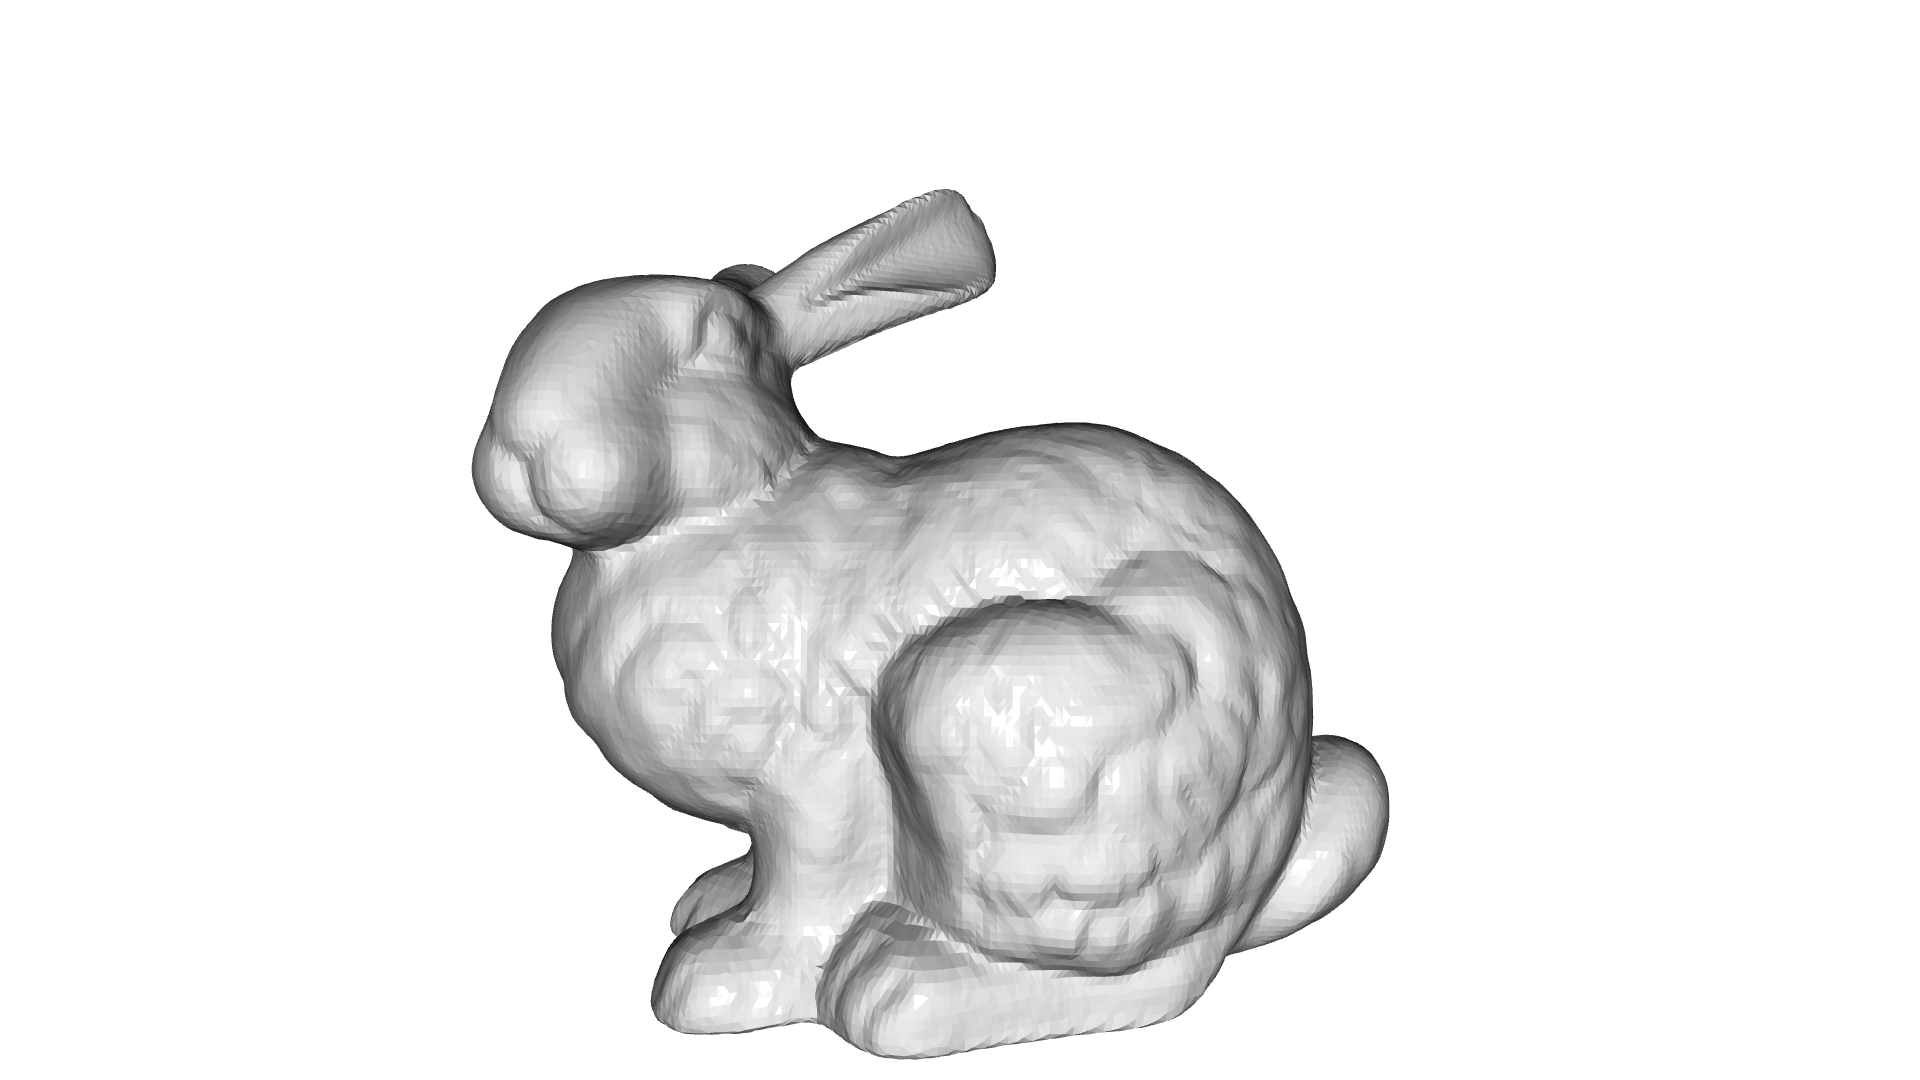

voxelization


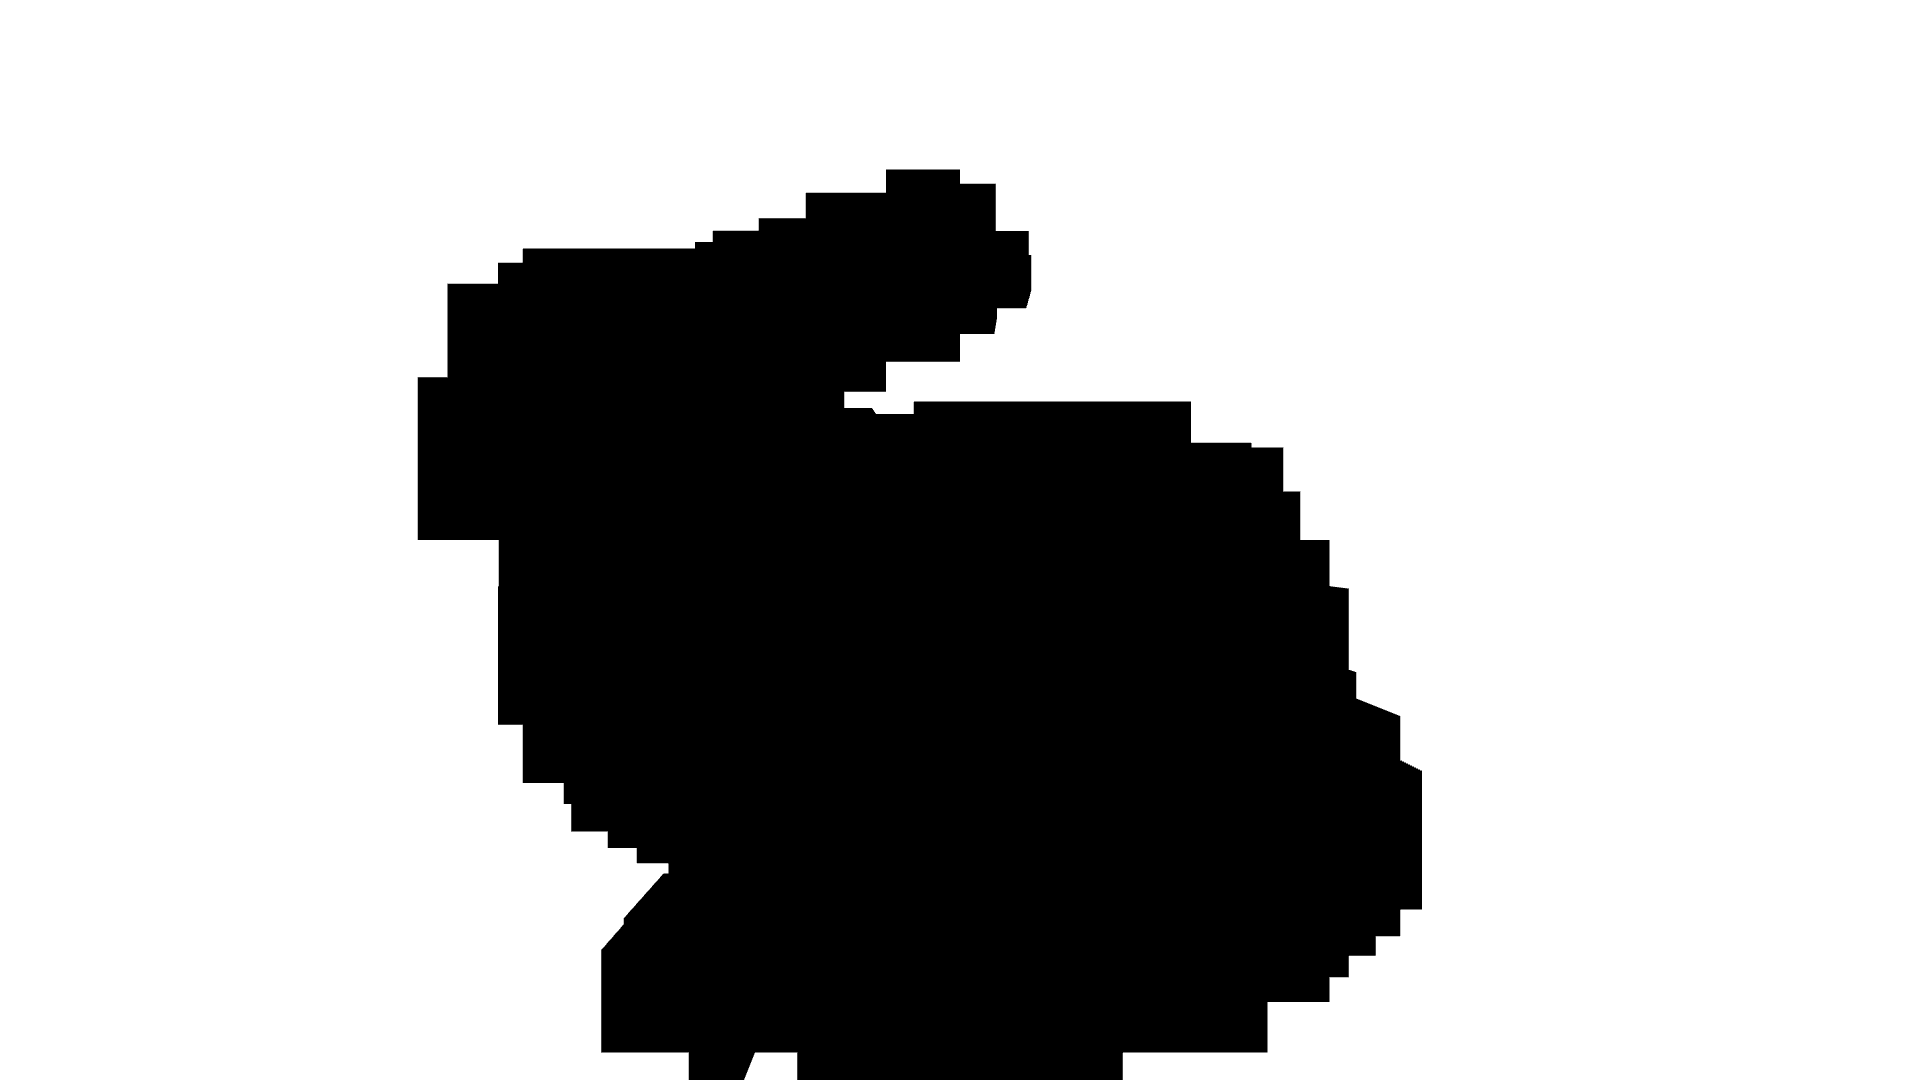

In [2]:
print('input')
mesh = o3dtut.get_bunny_mesh()
# fit to unit cube
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),
           center=mesh.get_center())
o3d.visualization.draw_geometries([mesh])

print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh,
                                                              voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])

## From point cloud
The voxel grid can also be created from a point cloud using the method `create_from_point_cloud`. A voxel is occupied if at least one point of the point cloud is within the voxel. The color of the voxel is the average of all the points within the voxel. The argument `voxel_size` defines the resolution of the voxel grid.

input


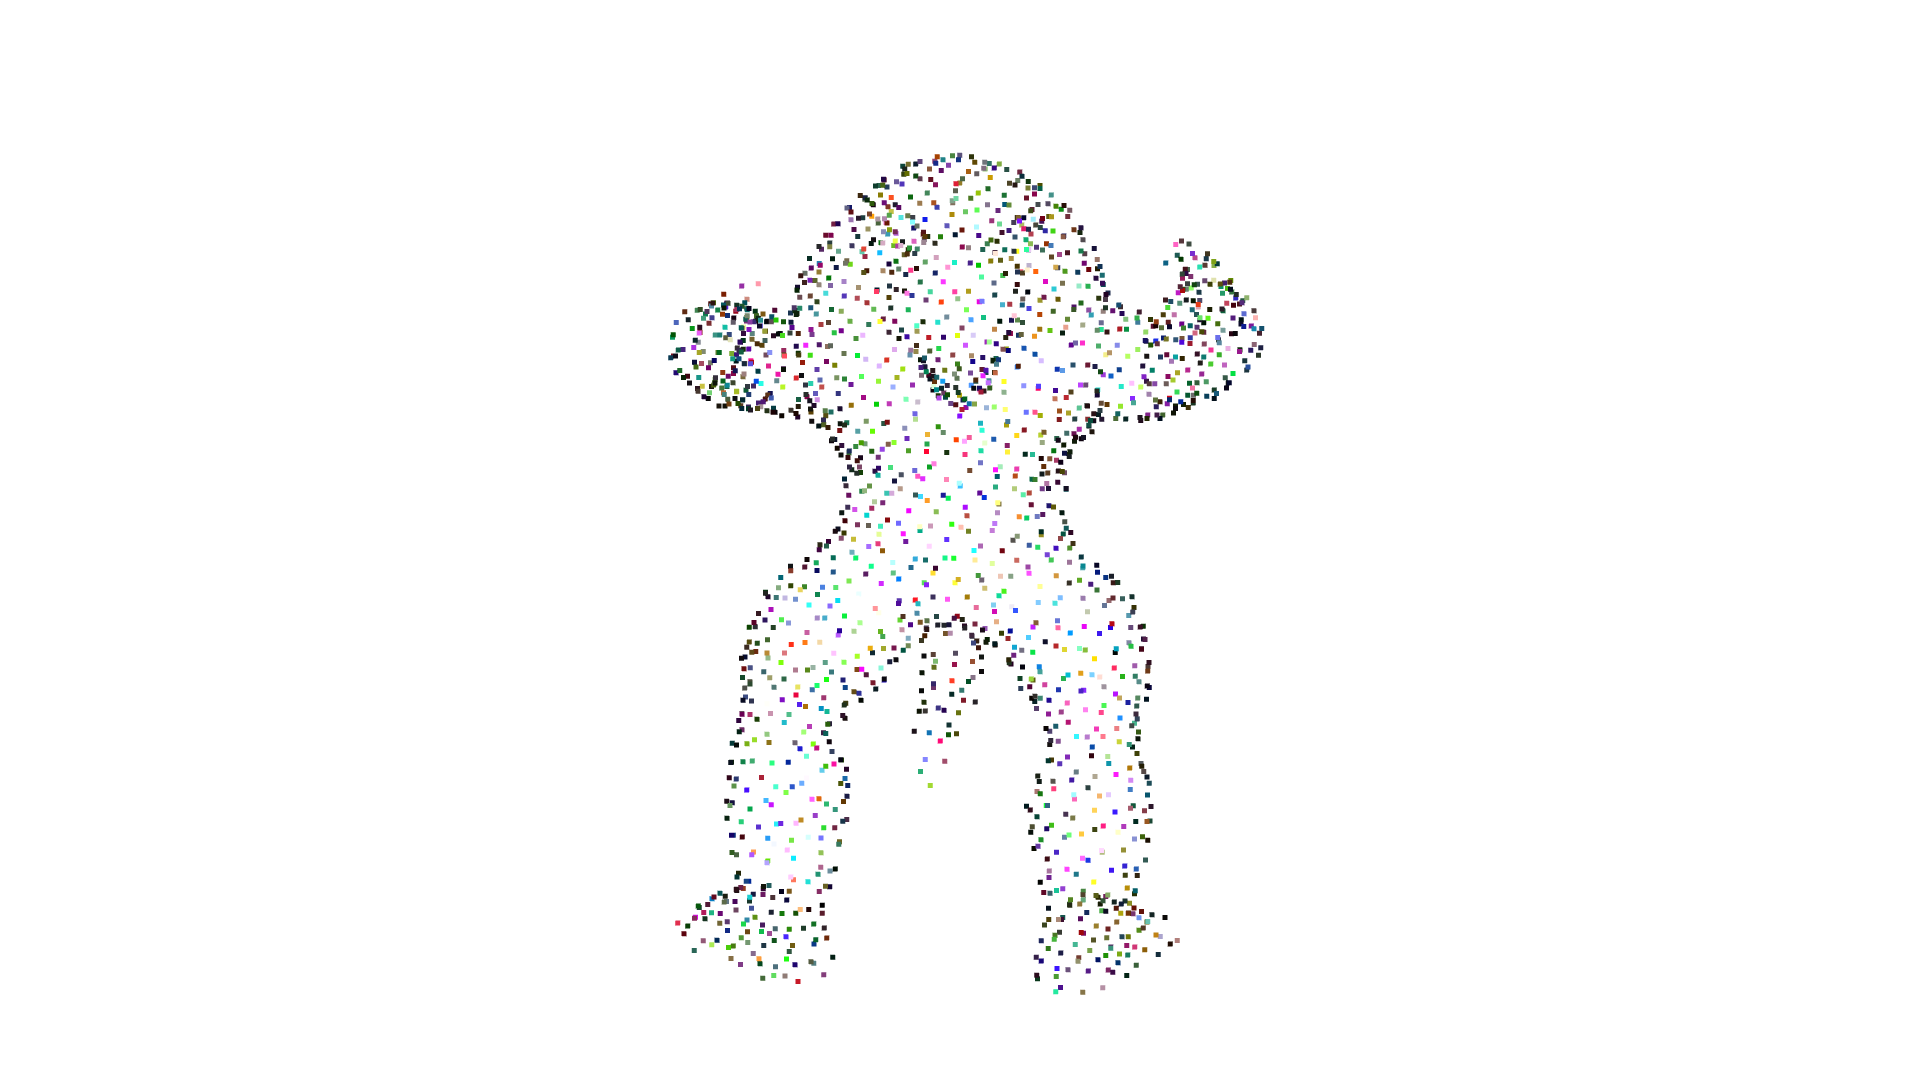

voxelization


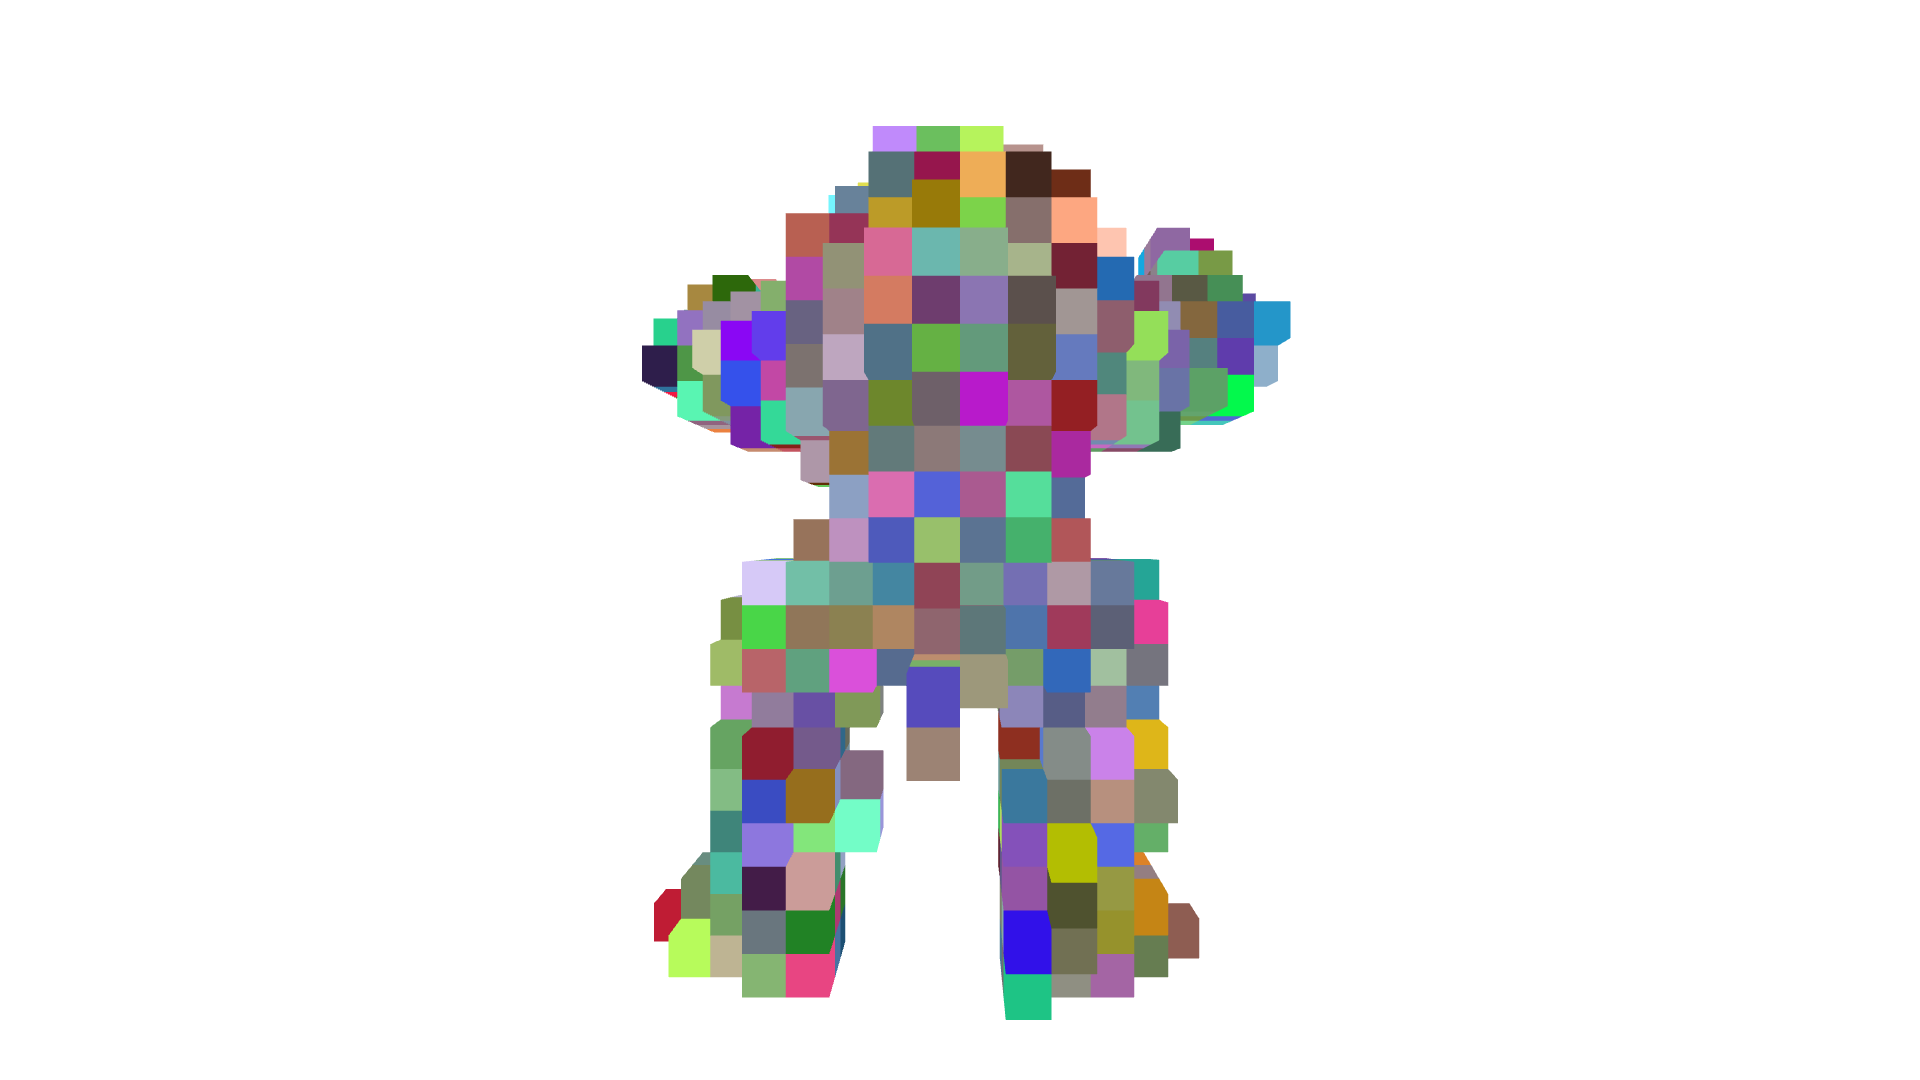

In [3]:
print('input')
N = 2000
pcd = o3dtut.get_armadillo_mesh().sample_points_poisson_disk(N)
# fit to unit cube
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
          center=pcd.get_center())
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))
o3d.visualization.draw_geometries([pcd])

print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])

## Inclusion test
The voxel grid can also be used to test if points are within an occupied voxel. The method `check_if_included` takes a `(n,3)` array as input and outputs a `bool` array.

In [4]:
queries = np.asarray(pcd.points)
output = voxel_grid.check_if_included(o3d.utility.Vector3dVector(queries))
print(output[:10])

[True, True, True, True, True, True, True, True, True, True]


## Voxel carving
The methods `create_from_point_cloud` and `create_from_triangle_mesh` create occupied voxels only on the surface of the geometry. It is however possible to carve a voxel grid from a number of depth maps or silhouettes. Open3D provides the methods `carve_depth_map` and `carve_silhouette` for voxel carving.

The code below demonstrates the usage by first rendering depthmaps from a geometry and using those depthmaps to carve a dense voxel grid. The result is a filled voxel grid of the given shape.

In [5]:
def xyz_spherical(xyz):
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    r = np.sqrt(x * x + y * y + z * z)
    r_x = np.arccos(y / r)
    r_y = np.arctan2(z, x)
    return [r, r_x, r_y]


def get_rotation_matrix(r_x, r_y):
    rot_x = np.asarray([[1, 0, 0], [0, np.cos(r_x), -np.sin(r_x)],
                        [0, np.sin(r_x), np.cos(r_x)]])
    rot_y = np.asarray([[np.cos(r_y), 0, np.sin(r_y)], [0, 1, 0],
                        [-np.sin(r_y), 0, np.cos(r_y)]])
    return rot_y.dot(rot_x)


def get_extrinsic(xyz):
    rvec = xyz_spherical(xyz)
    r = get_rotation_matrix(rvec[1], rvec[2])
    t = np.asarray([0, 0, 2]).transpose()
    trans = np.eye(4)
    trans[:3, :3] = r
    trans[:3, 3] = t
    return trans


def preprocess(model):
    min_bound = model.get_min_bound()
    max_bound = model.get_max_bound()
    center = min_bound + (max_bound - min_bound) / 2.0
    scale = np.linalg.norm(max_bound - min_bound) / 2.0
    vertices = np.asarray(model.vertices)
    vertices -= center
    model.vertices = o3d.utility.Vector3dVector(vertices / scale)
    return model


def voxel_carving(mesh,
                  output_filename,
                  camera_path,
                  cubic_size,
                  voxel_resolution,
                  w=300,
                  h=300,
                  use_depth=True,
                  surface_method='pointcloud'):
    mesh.compute_vertex_normals()
    camera_sphere = o3d.io.read_triangle_mesh(camera_path)

    # setup dense voxel grid
    voxel_carving = o3d.geometry.VoxelGrid.create_dense(
        width=cubic_size,
        height=cubic_size,
        depth=cubic_size,
        voxel_size=cubic_size / voxel_resolution,
        origin=[-cubic_size / 2.0, -cubic_size / 2.0, -cubic_size / 2.0],
        color=[1.0, 0.7, 0.0])

    # rescale geometry
    camera_sphere = preprocess(camera_sphere)
    mesh = preprocess(mesh)

    # setup visualizer to render depthmaps
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=w, height=h, visible=False)
    vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face = True
    ctr = vis.get_view_control()
    param = ctr.convert_to_pinhole_camera_parameters()

    # carve voxel grid
    pcd_agg = o3d.geometry.PointCloud()
    centers_pts = np.zeros((len(camera_sphere.vertices), 3))
    for cid, xyz in enumerate(camera_sphere.vertices):
        # get new camera pose
        trans = get_extrinsic(xyz)
        param.extrinsic = trans
        c = np.linalg.inv(trans).dot(np.asarray([0, 0, 0, 1]).transpose())
        centers_pts[cid, :] = c[:3]
        ctr.convert_from_pinhole_camera_parameters(param)

        # capture depth image and make a point cloud
        vis.poll_events()
        vis.update_renderer()
        depth = vis.capture_depth_float_buffer(False)
        pcd_agg += o3d.geometry.PointCloud.create_from_depth_image(
            o3d.geometry.Image(depth),
            param.intrinsic,
            param.extrinsic,
            depth_scale=1)

        # depth map carving method
        if use_depth:
            voxel_carving.carve_depth_map(o3d.geometry.Image(depth), param)
        else:
            voxel_carving.carve_silhouette(o3d.geometry.Image(depth), param)
        print("Carve view %03d/%03d" % (cid + 1, len(camera_sphere.vertices)))
    vis.destroy_window()

    # add voxel grid survace
    print('Surface voxel grid from %s' % surface_method)
    if surface_method == 'pointcloud':
        voxel_surface = o3d.geometry.VoxelGrid.create_from_point_cloud_within_bounds(
            pcd_agg,
            voxel_size=cubic_size / voxel_resolution,
            min_bound=(-cubic_size / 2, -cubic_size / 2, -cubic_size / 2),
            max_bound=(cubic_size / 2, cubic_size / 2, cubic_size / 2))
    elif surface_method == 'mesh':
        voxel_surface = o3d.geometry.VoxelGrid.create_from_triangle_mesh_within_bounds(
            mesh,
            voxel_size=cubic_size / voxel_resolution,
            min_bound=(-cubic_size / 2, -cubic_size / 2, -cubic_size / 2),
            max_bound=(cubic_size / 2, cubic_size / 2, cubic_size / 2))
    else:
        raise Exception('invalid surface method')
    voxel_carving_surface = voxel_surface + voxel_carving

    return voxel_carving_surface, voxel_carving, voxel_surface

In [6]:
mesh = o3dtut.get_armadillo_mesh()

output_filename = o3dtut.get_data_path_common("voxelized.ply")
camera_path = o3dtut.get_data_path_common("sphere.ply")
visualization = True
cubic_size = 2.0
voxel_resolution = 128.0

voxel_grid, voxel_carving, voxel_surface = voxel_carving(
    mesh, output_filename, camera_path, cubic_size, voxel_resolution)

Carve view 001/642
Carve view 002/642
Carve view 003/642
Carve view 004/642
Carve view 005/642
Carve view 006/642
Carve view 007/642
Carve view 008/642
Carve view 009/642
Carve view 010/642
Carve view 011/642
Carve view 012/642
Carve view 013/642
Carve view 014/642
Carve view 015/642
Carve view 016/642
Carve view 017/642
Carve view 018/642
Carve view 019/642
Carve view 020/642
Carve view 021/642
Carve view 022/642
Carve view 023/642
Carve view 024/642
Carve view 025/642
Carve view 026/642
Carve view 027/642
Carve view 028/642
Carve view 029/642
Carve view 030/642
Carve view 031/642
Carve view 032/642
Carve view 033/642
Carve view 034/642
Carve view 035/642
Carve view 036/642
Carve view 037/642
Carve view 038/642
Carve view 039/642
Carve view 040/642
Carve view 041/642
Carve view 042/642
Carve view 043/642
Carve view 044/642
Carve view 045/642
Carve view 046/642
Carve view 047/642
Carve view 048/642
Carve view 049/642
Carve view 050/642
Carve view 051/642
Carve view 052/642
Carve view 0

surface voxels
VoxelGrid with 18982 voxels.


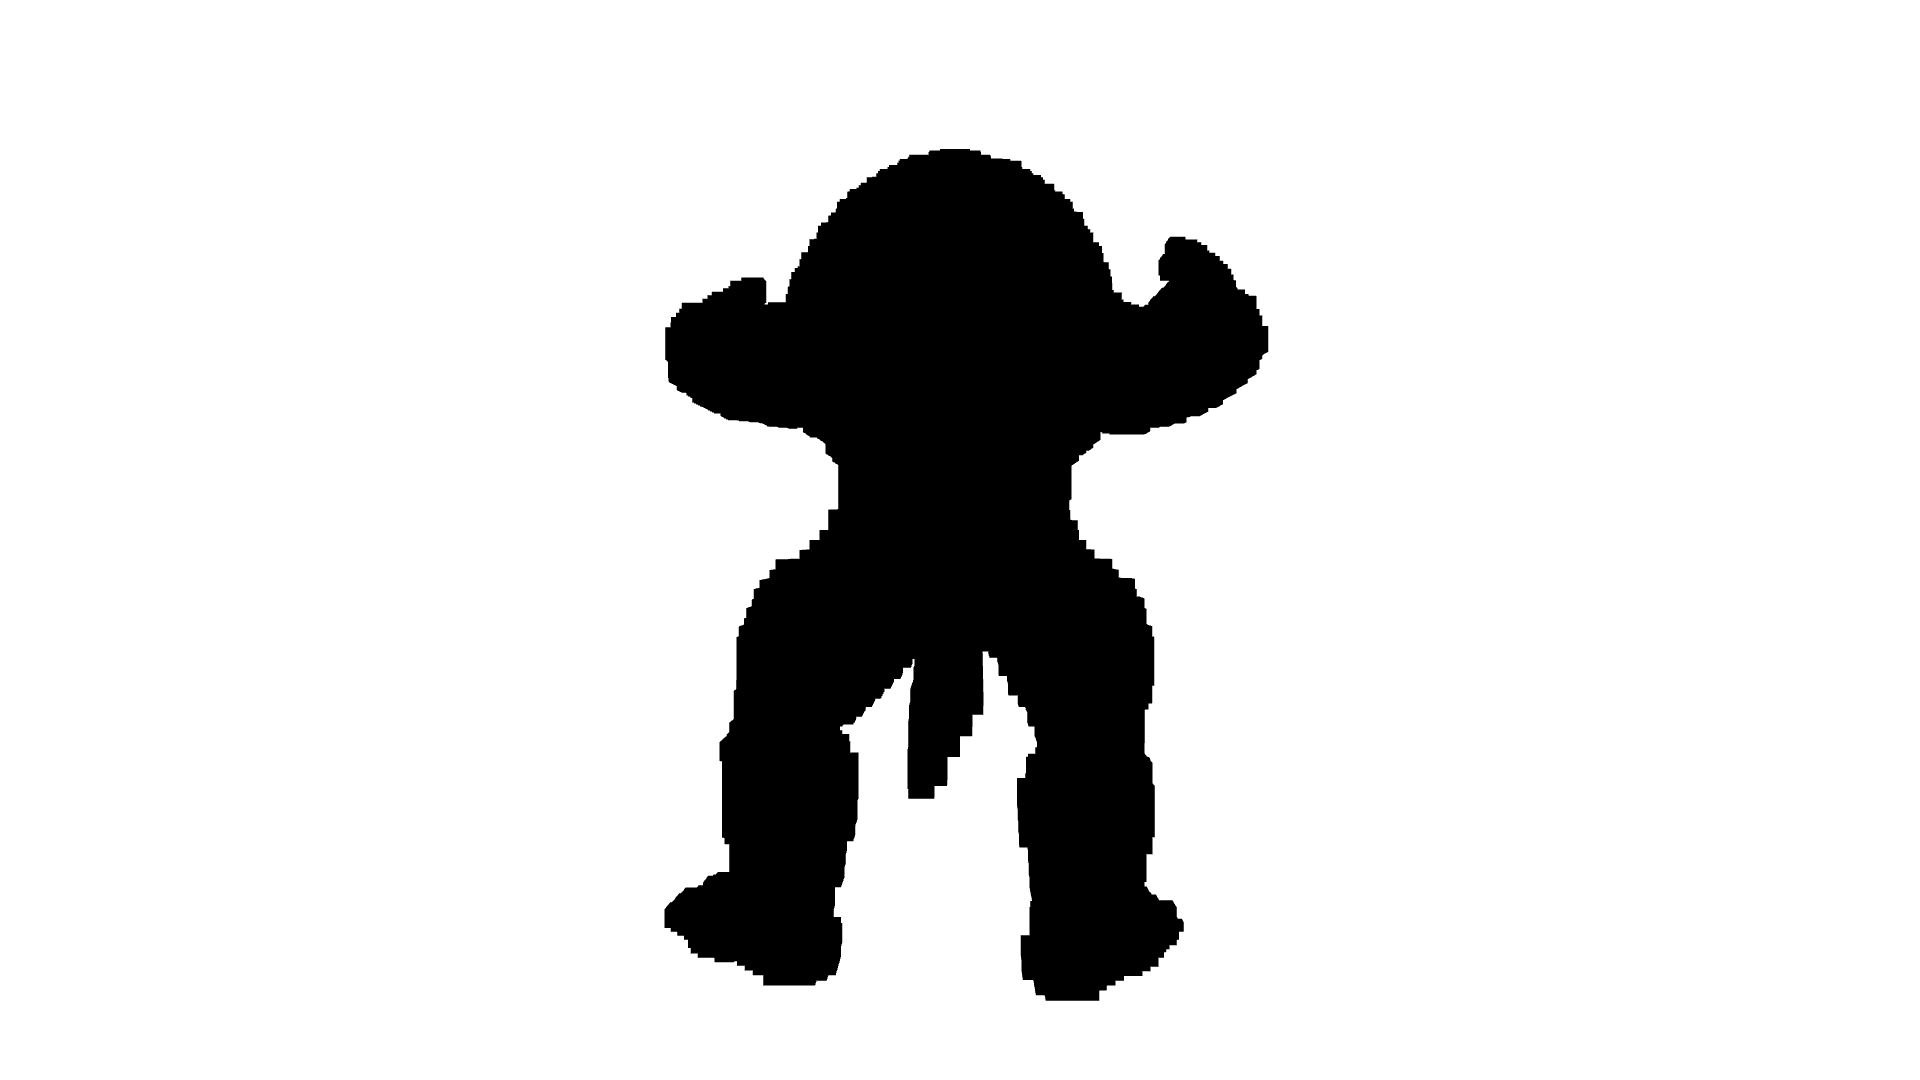

carved voxels
VoxelGrid with 47911 voxels.


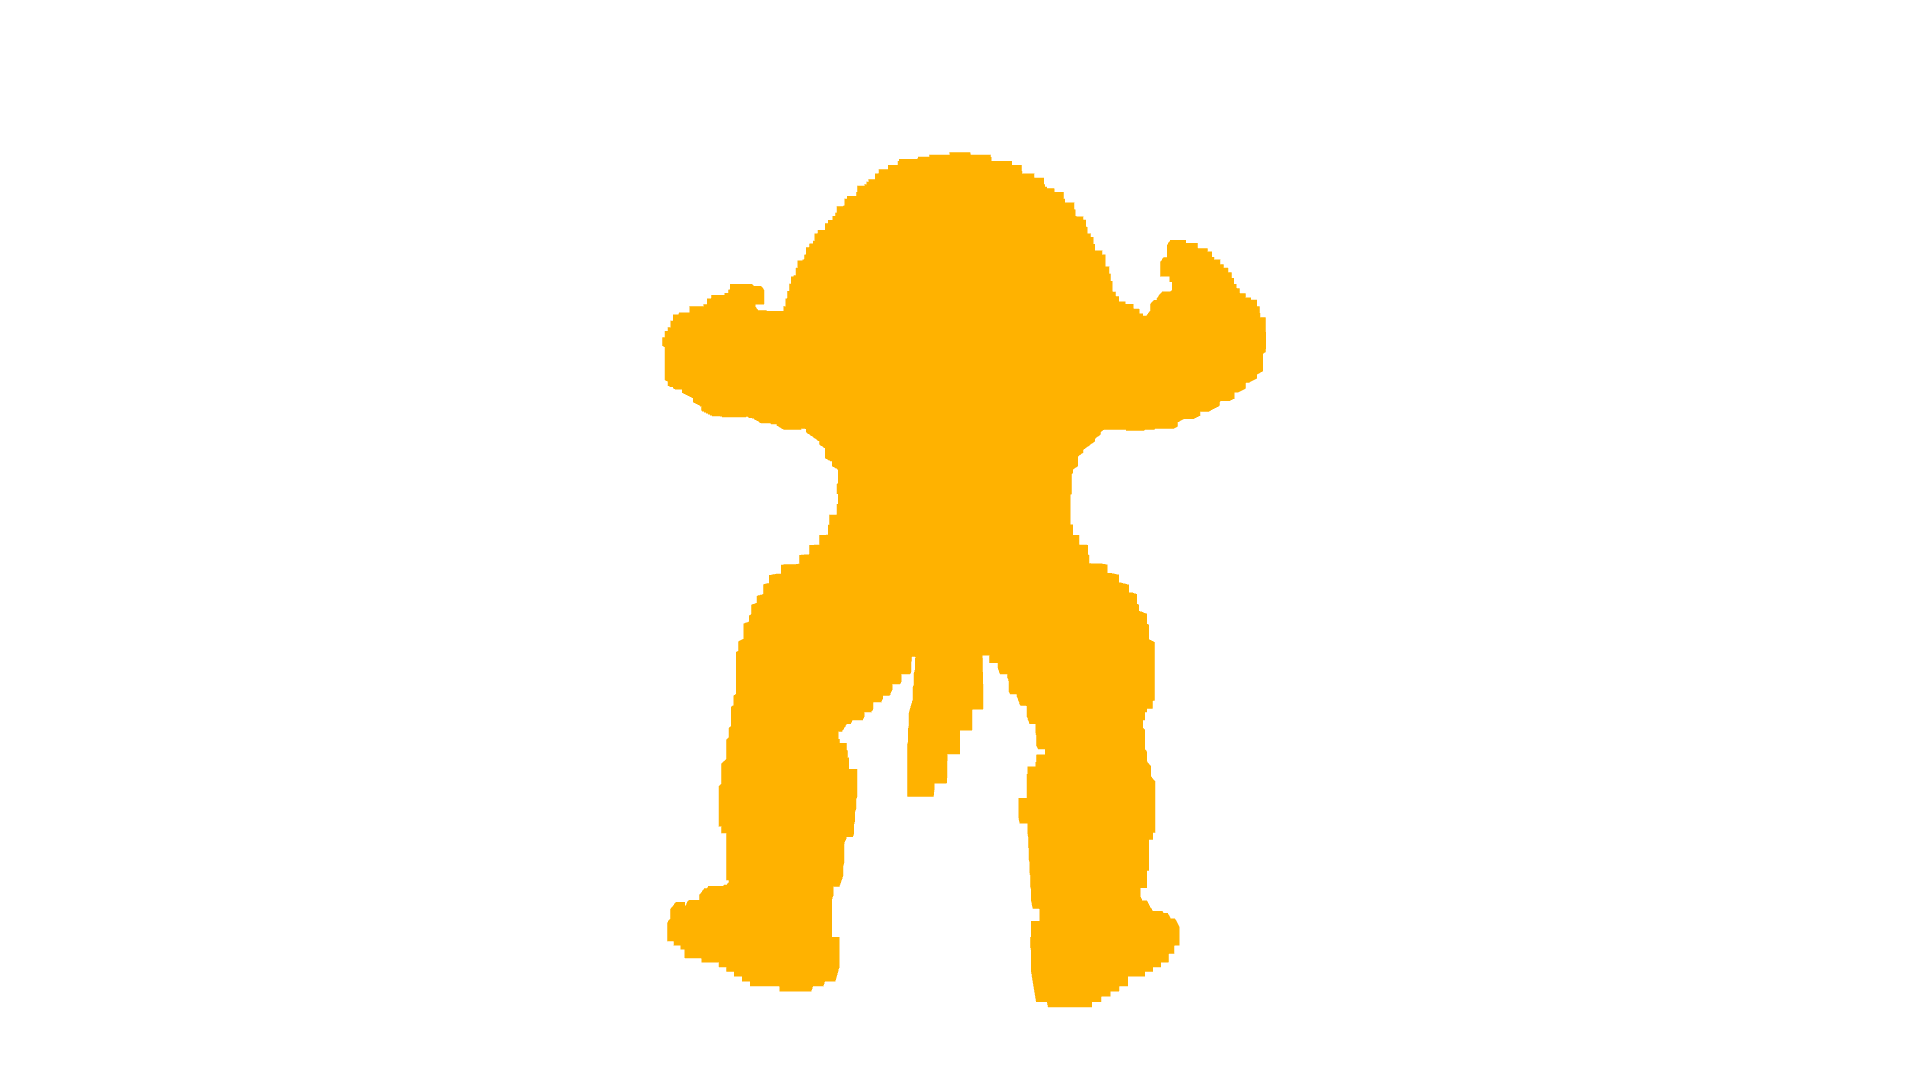

combined voxels (carved + surface)
VoxelGrid with 51863 voxels.


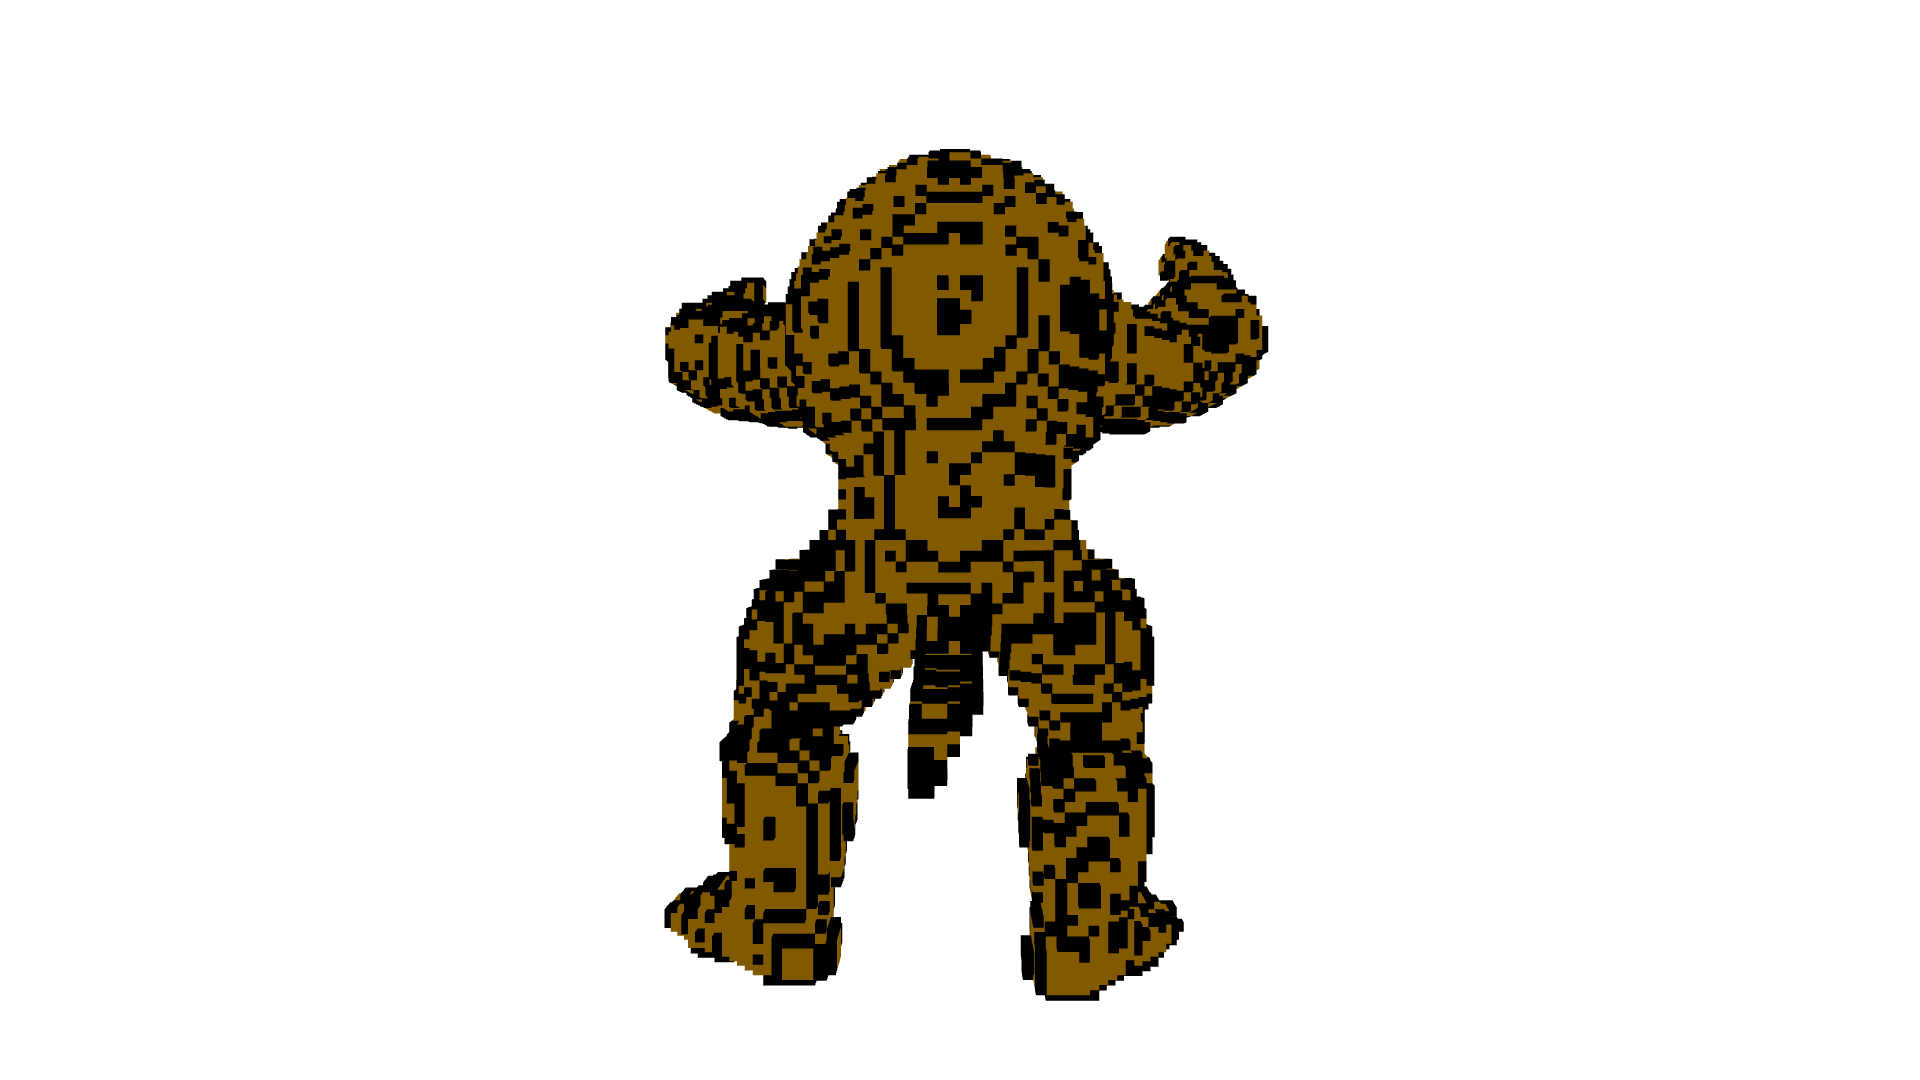

In [7]:
print("surface voxels")
print(voxel_surface)
o3d.visualization.draw_geometries([voxel_surface])

print("carved voxels")
print(voxel_carving)
o3d.visualization.draw_geometries([voxel_carving])

print("combined voxels (carved + surface)")
print(voxel_grid)
o3d.visualization.draw_geometries([voxel_grid])